# Modern-CNN

&copy; 李浩东 haodongli@zju.edu.cn

- Learning Representations
- AlexNet
- Networks Using Blocks (VGG)
- Network in Network (NiN)
- Networks with Parallel Concatenations (GoogLeNet)
- Residual Networks (ResNet)
- Densely Connected Networks (DenseNet)


# Learning Representations

- Up until 2012 the representation was calculated mechanically. In fact, engineering a new set of feature functions, improving results, and writing up the method was a prominent genre of paper. Like some functions in OpenCV.
- Features themselves ought to be learned, to be hierarchically composed with multiple jointly learned layers, each with learnable parameters.

![filters.png](./images/8/filters.png)



![ww](./images/8/alexnet.png)


# From LeNet (left) to AlexNet (right)

![alexnet.svg](./images/8/alexnet.svg)


In [1]:
import torch
from torch import nn
print(torch.__version__)

1.10.0+cu113


In [2]:
def alexnet():
    alexnet = nn.Sequential(
        # Here, we use a larger 11 x 11 window to capture objects. At the same
        # time, we use a stride of 4 to greatly reduce the height and width of the
        # output. Here, the number of output channels is much larger than that in
        # LeNet
        nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the number of
        # output channels
        nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of output
        # channels is further increased. Pooling layers are not used to reduce the
        # height and width of input after the first two convolutional layers
        nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Flatten(),
        # Here, the number of outputs of the fully-connected layer is several
        # times larger than that in LeNet. Use the dropout layer to mitigate
        # overfitting
        nn.Linear(6400, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        # Output layer. Since we are using CIFAR-10, the number of classes is
        # 10, instead of 1000 as in the paper
        nn.Linear(4096, 10))
    return alexnet

In [3]:
X = torch.randn(128, 3, 224, 224)
alex = alexnet()
for layer in alex:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([128, 96, 54, 54])
ReLU output shape:	 torch.Size([128, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([128, 96, 26, 26])
Conv2d output shape:	 torch.Size([128, 256, 26, 26])
ReLU output shape:	 torch.Size([128, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([128, 256, 12, 12])
Conv2d output shape:	 torch.Size([128, 384, 12, 12])
ReLU output shape:	 torch.Size([128, 384, 12, 12])
Conv2d output shape:	 torch.Size([128, 384, 12, 12])
ReLU output shape:	 torch.Size([128, 384, 12, 12])
Conv2d output shape:	 torch.Size([128, 256, 12, 12])
ReLU output shape:	 torch.Size([128, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([128, 256, 5, 5])
Flatten output shape:	 torch.Size([128, 6400])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 4096])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 409

In [4]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.model = alexnet()
    def forward(self, x):
        x = self.model(x)
        return x

In [5]:
print(alexnet())

Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=6400, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4096, out_features=4096, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_featu

In [2]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(224),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                ])
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
print(len(train_data))
print(len(test_data))

Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [4]:
num_workers = 0
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 224, 224])
torch.Size([128])


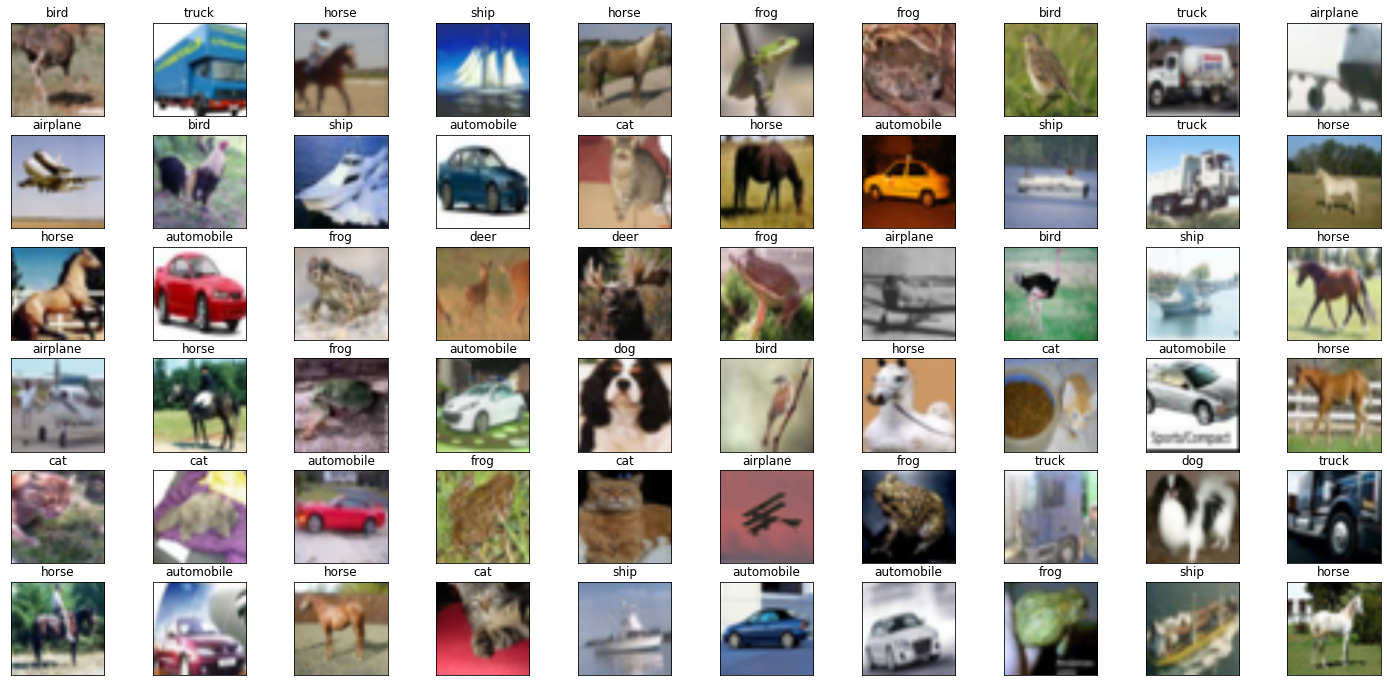

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
fig = plt.figure(figsize=(25, 12))
for i in np.arange(60):
    ax = fig.add_subplot(6, 10, i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

<class 'numpy.ndarray'>
(3, 224, 224)


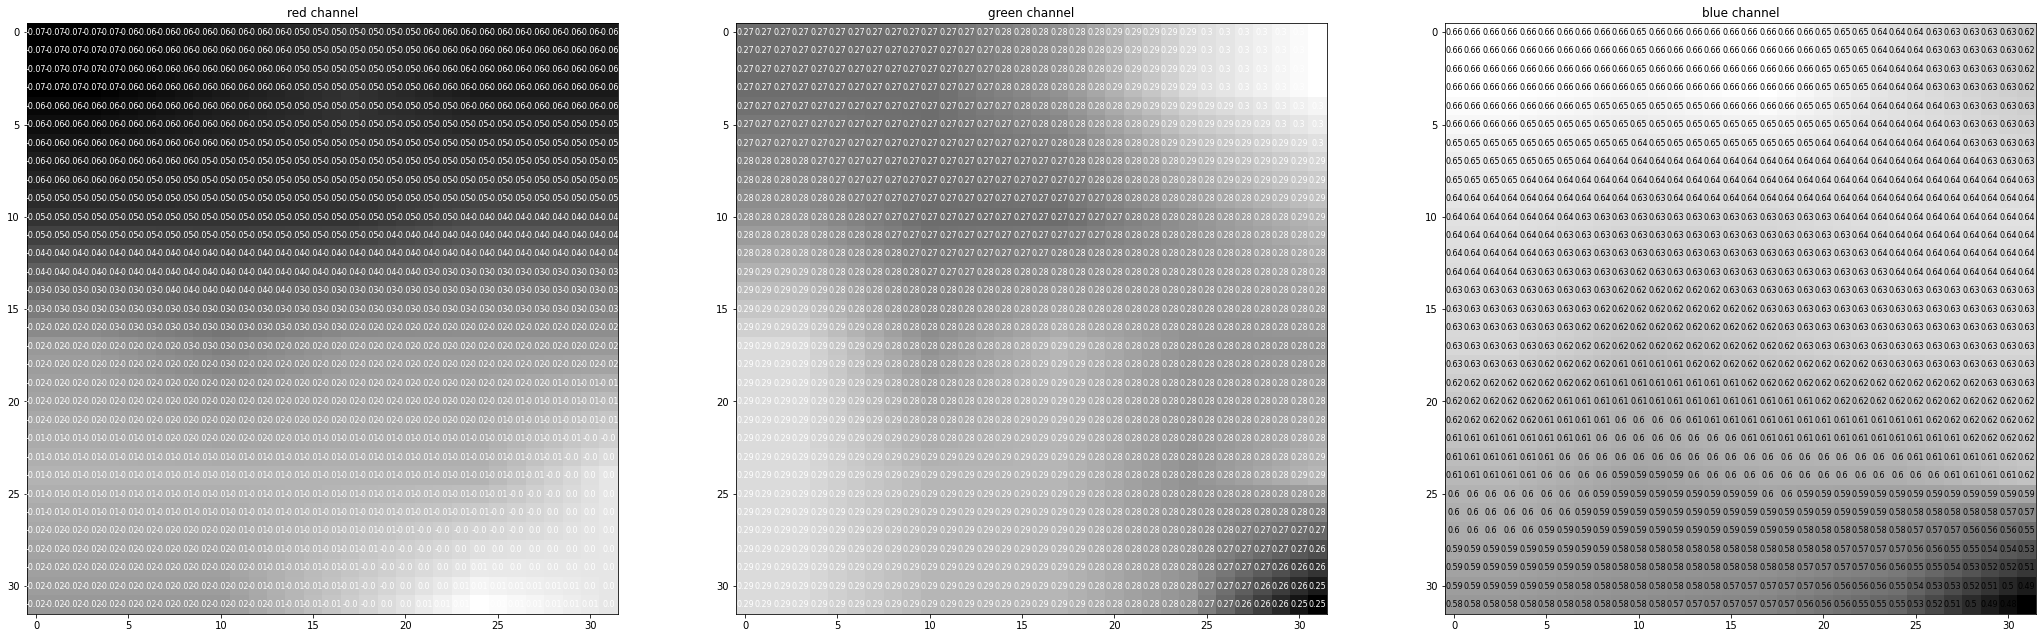

In [6]:
rgb_img = np.squeeze(images[19])
print(type(rgb_img))
print(rgb_img.shape)
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img[:32, :32], cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(32):
        for y in range(32):
            val = round(img[x][y], 2) if img[x][y] != 0 else 0
            ax.annotate(str(val), xy=(y,x),
                horizontalalignment='center',
                verticalalignment='center', size=8,
                color='white' if img[x][y] < thresh else 'black')

In [5]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_model(model, name, epoch_num=500, device='cuda', learning_rate=0.01, train_loader=train_loader, test_loader=test_loader):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weights)
    if device == 'cuda':
        print("Use CUDA for training.")
        model = torch.nn.DataParallel(model) # make parallel
        cudnn.benchmark = True
    
    model.to(device)
    # specify loss function
    criterion = nn.CrossEntropyLoss()
    # specify optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train_losslist = []
    valid_losslist = []
    train_acclist = []
    valid_acclist = []

    for epoch in range(1, epoch_num+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0

        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            acc = accuracy(output, target)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            train_acc += acc.item()*data.size(0)

        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            acc = accuracy(output, target)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_acc += acc.item()*data.size(0)

        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        train_acc = train_acc/len(train_loader.dataset)
        valid_acc = valid_acc/len(test_loader.dataset)
        train_losslist.append(train_loss)
        valid_losslist.append(valid_loss)
        train_acclist.append(train_acc)
        valid_acclist.append(valid_acc)
        print("Epoch ->", epoch, "\t train_loss ->", train_loss, "\t\t\t train_acc ->", train_acc, 
              "\n==========\t valid_loss ->", valid_loss, "\t\t\t valid_acc ->", valid_acc)
    
    os.mkdir("./result/") if os.path.exists("./result/") == False else print("./result/ exists.")
    torch.save(model.state_dict(), './result/cifar_' + name + '.pt')
    return train_acclist, valid_acclist, train_losslist, valid_losslist

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(AlexNet(), "alexnet", 10, device, learning_rate=0.1)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 2.157024055786133 			 train_acc -> 0.19450000000476836 
==========	 valid_loss -> 1.9041380699157715 			 valid_acc -> 0.2916
Epoch -> 2 	 train_loss -> 1.7626686682891846 			 train_acc -> 0.35267999998092653 
==========	 valid_loss -> 1.63663171749115 			 valid_acc -> 0.412
Epoch -> 3 	 train_loss -> 1.4755991777801514 			 train_acc -> 0.46270000001907347 
==========	 valid_loss -> 1.3701823890686036 			 valid_acc -> 0.5138
Epoch -> 4 	 train_loss -> 1.2465702711868285 			 train_acc -> 0.5558400000381469 
==========	 valid_loss -> 1.2205792970657348 			 valid_acc -> 0.5585
Epoch -> 5 	 train_loss -> 1.0468435781478882 			 train_acc -> 0.63272 
==========	 valid_loss -> 1.007874684715271 			 valid_acc -> 0.65
Epoch -> 6 	 train_loss -> 0.8842423446273804 			 train_acc -> 0.6907199999618531 
==========	 valid_loss -> 1.1401259311676026 			 valid_acc -> 0.6046
Epoch -> 7 

In [6]:
def plot_accuracies(train_acclist, valid_acclist):
    plt.plot(train_acclist, '-rx')
    plt.plot(valid_acclist, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(train_losslist, valid_losslist):
    plt.plot(train_losslist, '-bx')
    plt.plot(valid_losslist, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

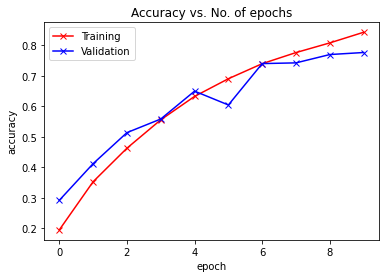

In [14]:
plot_accuracies(train_acclist, valid_acclist)

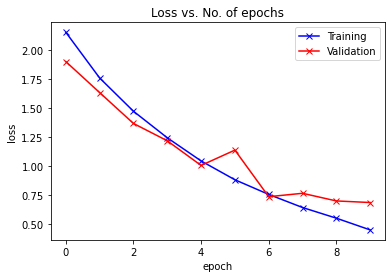

In [15]:
plot_losses(train_losslist, valid_losslist)

# Networks Using Blocks (VGG)

- While AlexNet offered empirical evidence that deep CNNs can achieve good results, it did not provide a general template to guide subsequent researchers in designing new networks.
- The basic building block of classic CNNs is a sequence of the following:
    - (i) a convolutional layer with padding to maintain the resolution, 
    - (ii) a nonlinearity such as a ReLU, 
    - (iii) a pooling layer such as a maximum pooling layer. 
- One VGG block consists of a sequence of convolutional layers, followed by a maximum pooling layer for spatial downsampling.



![vgg](./images/8/vgg.png)


# AlexNet V.S. VGG

![1](./images/8/vgg.svg)


In [6]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [10]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 3
    # The convolutional part
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
vggnet = vgg(conv_arch)

In [11]:
print(vggnet)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4):

In [19]:
X = torch.randn(size=(128, 3, 224, 224))
for blk in vggnet:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([128, 64, 112, 112])
Sequential output shape:	 torch.Size([128, 128, 56, 56])
Sequential output shape:	 torch.Size([128, 256, 28, 28])
Sequential output shape:	 torch.Size([128, 512, 14, 14])
Sequential output shape:	 torch.Size([128, 512, 7, 7])
Flatten output shape:	 torch.Size([128, 25088])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 4096])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 4096])
Linear output shape:	 torch.Size([128, 10])


In [12]:
class VGGNet(nn.Module):
    def __init__(self, conv_arch):
        super(VGGNet, self).__init__()
        self.model = vgg(conv_arch)
    def forward(self, x):
        x = self.model(x)
        return x

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(VGGNet(conv_arch), "vggnet", 10, device, learning_rate=0.1)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 2.302887268371582 			 train_acc -> 0.09755999999523163 
==========	 valid_loss -> 2.3028270275115967 			 valid_acc -> 0.0995
Epoch -> 2 	 train_loss -> 2.3027088862609864 			 train_acc -> 0.09872 
==========	 valid_loss -> 2.302776969909668 			 valid_acc -> 0.0998
Epoch -> 3 	 train_loss -> 2.3028810122680663 			 train_acc -> 0.09892 
==========	 valid_loss -> 2.3026444580078125 			 valid_acc -> 0.1
Epoch -> 4 	 train_loss -> 2.3023598937988283 			 train_acc -> 0.10355999999523163 
==========	 valid_loss -> 2.2998690208435058 			 valid_acc -> 0.1083
Epoch -> 5 	 train_loss -> 2.219375960121155 			 train_acc -> 0.1754000000190735 
==========	 valid_loss -> 2.0665507686614992 			 valid_acc -> 0.2673
Epoch -> 6 	 train_loss -> 1.9155887814712524 			 train_acc -> 0.29143999999046327 
==========	 valid_loss -> 1.6988265672683716 			 valid_acc -> 0.3706
Epoch -> 7 	 train_lo

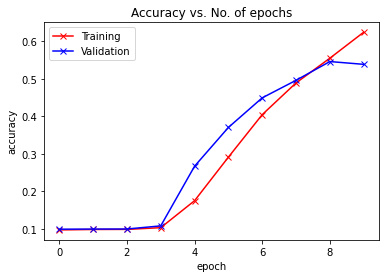

In [31]:
plot_accuracies(train_acclist, valid_acclist)

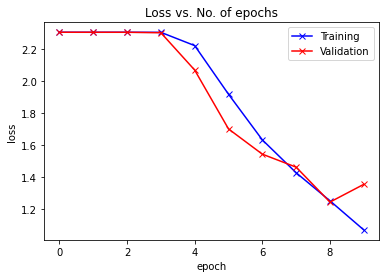

In [32]:
plot_losses(train_losslist, valid_losslist)

In [13]:
ratio = 4
conv_arch_small = [(pair[0], pair[1] // ratio) for pair in conv_arch]
vggnet_small = vgg(conv_arch_small)

In [14]:
print(vggnet_small)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Seque

In [15]:
X = torch.randn(size=(128, 3, 224, 224))
for blk in vggnet_small:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([128, 16, 112, 112])
Sequential output shape:	 torch.Size([128, 32, 56, 56])
Sequential output shape:	 torch.Size([128, 64, 28, 28])
Sequential output shape:	 torch.Size([128, 128, 14, 14])
Sequential output shape:	 torch.Size([128, 128, 7, 7])
Flatten output shape:	 torch.Size([128, 6272])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 4096])
Linear output shape:	 torch.Size([128, 4096])
ReLU output shape:	 torch.Size([128, 4096])
Dropout output shape:	 torch.Size([128, 4096])
Linear output shape:	 torch.Size([128, 10])


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(VGGNet(conv_arch_small), "vggnet_small", 10, device, learning_rate=0.1)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 2.302932787628174 			 train_acc -> 0.0960600000011921 
==========	 valid_loss -> 2.3026234802246095 			 valid_acc -> 0.0993
Epoch -> 2 	 train_loss -> 2.30281301864624 			 train_acc -> 0.09902000000476838 
==========	 valid_loss -> 2.3028244819641115 			 valid_acc -> 0.0973
Epoch -> 3 	 train_loss -> 2.302931197052002 			 train_acc -> 0.09988000000238419 
==========	 valid_loss -> 2.3027171588897706 			 valid_acc -> 0.1
Epoch -> 4 	 train_loss -> 2.3028813500976564 			 train_acc -> 0.09903999999523162 
==========	 valid_loss -> 2.302652516937256 			 valid_acc -> 0.1
Epoch -> 5 	 train_loss -> 2.302744821548462 			 train_acc -> 0.10022000000476837 
==========	 valid_loss -> 2.302427421569824 			 valid_acc -> 0.1028
Epoch -> 6 	 train_loss -> 2.256916834716797 			 train_acc -> 0.14739999999046324 
==========	 valid_loss -> 2.056313734817505 			 valid_acc -> 0.2518
Epoch 

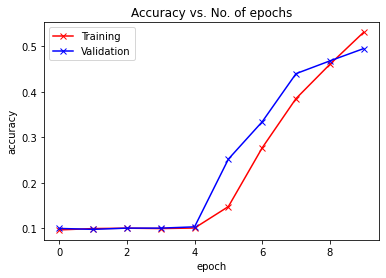

In [19]:
plot_accuracies(train_acclist, valid_acclist)

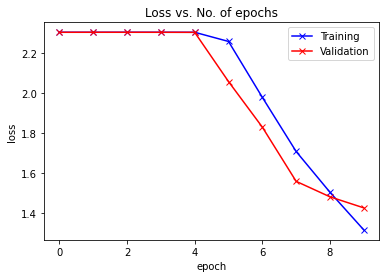

In [20]:
plot_losses(train_losslist, valid_losslist)

# Network in Network (NiN)

- LeNet, AlexNet, and VGG all share a common design pattern: extract features exploiting spatial structure via a sequence of convolution and pooling layers and then post-process the representations via fully-connected layers. 
- The improvements upon LeNet by AlexNet and VGG mainly lie in how these later networks widen and deepen these two modules. 
- Alternatively, one could imagine using fully-connected layers earlier in the process. However, a careless use of dense layers might give up the spatial structure of the representation entirely, network in network (NiN) blocks offer an alternative.
- Recall that the inputs and outputs of convolutional layers consist of four-dimensional tensors with axes corresponding to the example, channel, height, and width. Also recall that the inputs and outputs of fully-connected layers are typically two-dimensional tensors corresponding to the example and feature. 
- The idea behind NiN is to apply a fully-connected layer at each pixel location (for each height and width). If we tie the weights across each spatial location, we could think of this as a $1\times 1$ convolutional layer or as a fully-connected layer acting independently on each pixel location.

![nin](./images/8/nin.png)

# VGG V.S. NIN

![1](./images/8/nin.svg)

In [7]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

In [8]:
def nin_net(init=3):
    net = nn.Sequential(
        nin_block(init, 96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2d(3, stride=2),
        nin_block(96, 256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2d(3, stride=2),
        nin_block(256, 384, kernel_size=3, strides=1, padding=1),
        nn.MaxPool2d(3, stride=2),
        nn.Dropout(0.5),
        # There are 10 label classes
        nin_block(384, 10, kernel_size=3, strides=1, padding=1),
        nn.AdaptiveAvgPool2d((1, 1)),
        # Transform the four-dimensional output into two-dimensional output with a
        # shape of (batch size, 10)
        nn.Flatten())
    return net

In [9]:
ninnet = nin_net()
print(ninnet)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (5): MaxPool2d(kernel_size=3, stri

In [10]:
X = torch.rand(size=(128, 3, 224, 224))
for layer in ninnet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([128, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([128, 96, 26, 26])
Sequential output shape:	 torch.Size([128, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([128, 256, 12, 12])
Sequential output shape:	 torch.Size([128, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([128, 384, 5, 5])
Dropout output shape:	 torch.Size([128, 384, 5, 5])
Sequential output shape:	 torch.Size([128, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([128, 10, 1, 1])
Flatten output shape:	 torch.Size([128, 10])


In [11]:
class NINNet(nn.Module):
    def __init__(self, init=3):
        super(NINNet, self).__init__()
        self.model = nin_net(init)
    def forward(self, x):
        x = self.model(x)
        return x

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(NINNet(), "ninnet", 10, device, learning_rate=0.1)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 2.2716424184417723 			 train_acc -> 0.14883999999523162 
==========	 valid_loss -> 2.238493511581421 			 valid_acc -> 0.1781
Epoch -> 2 	 train_loss -> 2.2077856161499025 			 train_acc -> 0.2029 
==========	 valid_loss -> 2.202296000289917 			 valid_acc -> 0.1922
Epoch -> 3 	 train_loss -> 2.058752469787598 			 train_acc -> 0.25323999999046326 
==========	 valid_loss -> 2.0676619987487794 			 valid_acc -> 0.2335
Epoch -> 4 	 train_loss -> 1.8881954986953735 			 train_acc -> 0.3089399999809265 
==========	 valid_loss -> 1.7501305557250977 			 valid_acc -> 0.3692
Epoch -> 5 	 train_loss -> 1.719094507522583 			 train_acc -> 0.37328 
==========	 valid_loss -> 1.5199052526474 			 valid_acc -> 0.4385
Epoch -> 6 	 train_loss -> 1.528047755355835 			 train_acc -> 0.44032 
==========	 valid_loss -> 1.4931044549942016 			 valid_acc -> 0.4402
Epoch -> 7 	 

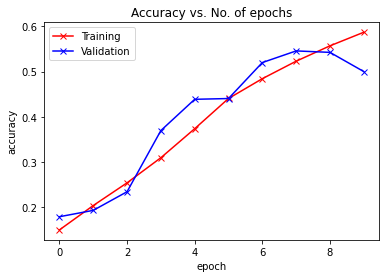

In [19]:
plot_accuracies(train_acclist, valid_acclist)

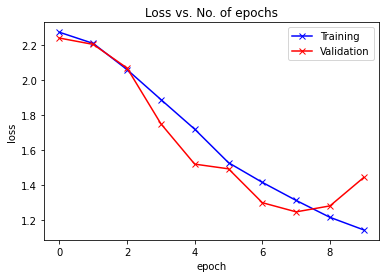

In [20]:
plot_losses(train_losslist, valid_losslist)

In [22]:
transform_mnist = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize(224),
                                      transforms.Normalize(mean=0.5, std=0.5)
                                      ])
train_data_mnist = datasets.MNIST('data', train=True,
                              download=True, transform=transform_mnist)
test_data_mnist = datasets.MNIST('data', train=False,
                             download=True, transform=transform_mnist)
print(len(train_data_mnist))
print(len(test_data_mnist))

60000
10000


In [23]:
num_workers = 0
batch_size = 128
train_loader_mnist = DataLoader(dataset=train_data_mnist, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader_mnist = DataLoader(dataset=test_data_mnist, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataiter_mnist = iter(train_loader_mnist)
images, labels = next(dataiter_mnist)
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 224, 224])
torch.Size([128])


In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(NINNet(init=1), "ninnet", 10, device, learning_rate=0.1, 
                                                                          train_loader=train_loader_mnist, test_loader=test_loader_mnist)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 2.240266214497884 			 train_acc -> 0.15700000000794728 
==========	 valid_loss -> 2.090851889038086 			 valid_acc -> 0.265
Epoch -> 2 	 train_loss -> 1.8026232934316 			 train_acc -> 0.35354999996821085 
==========	 valid_loss -> 1.280316184425354 			 valid_acc -> 0.5193
Epoch -> 3 	 train_loss -> 0.9025306761900584 			 train_acc -> 0.6852833333015442 
==========	 valid_loss -> 0.47011683249473574 			 valid_acc -> 0.8373
Epoch -> 4 	 train_loss -> 0.43144029528299965 			 train_acc -> 0.8641666666348775 
==========	 valid_loss -> 0.2409975734949112 			 valid_acc -> 0.9238
Epoch -> 5 	 train_loss -> 0.6842060216625532 			 train_acc -> 0.769416666662693 
==========	 valid_loss -> 2.1980542934417726 			 valid_acc -> 0.2622
Epoch -> 6 	 train_loss -> 1.1660872381051381 			 train_acc -> 0.6012166666984559 
==========	 valid_loss -> 0.20291216678619384 

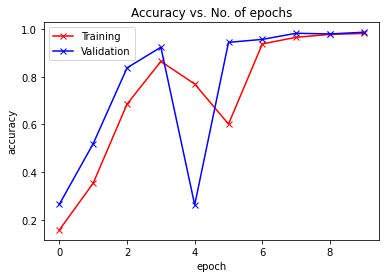

In [25]:
plot_accuracies(train_acclist, valid_acclist)

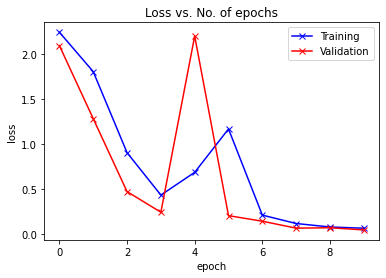

In [26]:
plot_losses(train_losslist, valid_losslist)

# Networks with Parallel Concatenations (GoogLeNet)

- In 2014, GoogLeNet won the ImageNet Challenge, proposing a structure that combined the strengths of NiN and paradigms of repeated blocks.
- One focus of the paper was to address the question of which sized convolution kernels are best.
- After all, previous popular networks employed choices as small as $1\times 1$ and as large as $11\times 11$. 
- One insight in this paper was that sometimes it can be advantageous to employ a combination of variously-sized kernels.


# Inception Blocks

![inception.svg](./images/8/inception.svg)


# GoogLeNet Model

![inception-full](./images/8/inception-full.svg)


In [27]:
class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

In [28]:
def google_net():
    b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

    net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))
    return net

In [29]:
googlenet = google_net()
X = torch.rand(size=(128, 3, 96, 96))
for layer in googlenet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([128, 64, 24, 24])
Sequential output shape:	 torch.Size([128, 192, 12, 12])
Sequential output shape:	 torch.Size([128, 480, 6, 6])
Sequential output shape:	 torch.Size([128, 832, 3, 3])
Sequential output shape:	 torch.Size([128, 1024])
Linear output shape:	 torch.Size([128, 10])


In [30]:
transform_google = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize(96),
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                       ])
train_data_google = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform_google)
test_data_google = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_google)
print(len(train_data_google))
print(len(test_data_google))
num_workers = 0
batch_size = 128
train_loader_google = DataLoader(dataset=train_data_google, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader_google = DataLoader(dataset=test_data_google, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [31]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.model = google_net()
    def forward(self, x):
        x = self.model(x)
        return x

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(GoogLeNet(), "googlenet", 10, device, learning_rate=0.1, 
                                                                          train_loader=train_loader_google, test_loader=test_loader_google)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 2.193687882156372 			 train_acc -> 0.1656800000011921 
==========	 valid_loss -> 2.1435350242614746 			 valid_acc -> 0.2237
Epoch -> 2 	 train_loss -> 1.9191141878890992 			 train_acc -> 0.2740599999809265 
==========	 valid_loss -> 1.7386830841064453 			 valid_acc -> 0.3254
Epoch -> 3 	 train_loss -> 1.7185773886108398 			 train_acc -> 0.35940000001907346 
==========	 valid_loss -> 1.8858260543823242 			 valid_acc -> 0.3148
Epoch -> 4 	 train_loss -> 1.564379836769104 			 train_acc -> 0.42971999999046323 
==========	 valid_loss -> 1.5143173091888427 			 valid_acc -> 0.4422
Epoch -> 5 	 train_loss -> 1.4038766767501831 			 train_acc -> 0.48994000000953675 
==========	 valid_loss -> 1.6000513280868531 			 valid_acc -> 0.397
Epoch -> 6 	 train_loss -> 1.2865461515045167 			 train_acc -> 0.535320000038147 
==========	 valid_loss -> 1.174482790565490

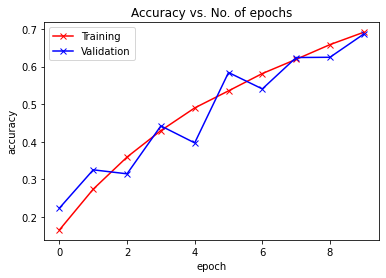

In [33]:
plot_accuracies(train_acclist, valid_acclist)

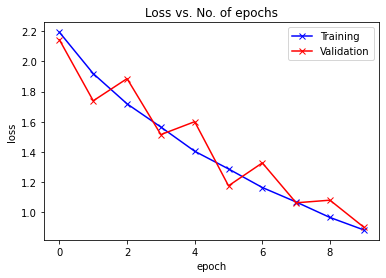

In [34]:
plot_losses(train_losslist, valid_losslist)

```python
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_model(model, name, epoch_num=500, device='cuda', learning_rate=0.01, train_loader=train_loader, test_loader=test_loader):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    model.apply(init_weights)
    if device == 'cuda':
        print("Use CUDA for training.")
        model = torch.nn.DataParallel(model) # make parallel
        cudnn.benchmark = True
    
    model.to(device)
    # specify loss function
    criterion = nn.CrossEntropyLoss()
    # specify optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    train_losslist = []
    valid_losslist = []
    train_acclist = []
    valid_acclist = []

    for epoch in range(1, epoch_num+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0

        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            acc = accuracy(output, target)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            train_acc += acc.item()*data.size(0)

        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            acc = accuracy(output, target)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_acc += acc.item()*data.size(0)

        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        train_acc = train_acc/len(train_loader.dataset)
        valid_acc = valid_acc/len(test_loader.dataset)
        train_losslist.append(train_loss)
        valid_losslist.append(valid_loss)
        train_acclist.append(train_acc)
        valid_acclist.append(valid_acc)
        print("Epoch ->", epoch, "\t train_loss ->", train_loss, "\t\t\t train_acc ->", train_acc, 
              "\n==========\t valid_loss ->", valid_loss, "\t\t\t valid_acc ->", valid_acc)
    
    os.mkdir("./result/")
    torch.save(model.state_dict(), './result/cifar_' + name + '.pt')
    return train_acclist, valid_acclist, train_losslist, valid_losslist
```

# Basic Elements

- Back Propagation
- Criterion
- Gradient Descent
- Optimizer

![11](./images/8/gd.png)


![11](./images/8/001.png)

![11](./images/8/002.png)

![11](./images/8/003.png)

![11](./images/8/004.png)

![11](./images/8/005.png)

![11](./images/8/006.png)

![11](./images/8/007.png)

![11](./images/8/008.png)

![11](./images/8/009.png)

![11](./images/8/010.png)

![11](./images/8/011.png)

![11](./images/8/012.png)

![11](./images/8/013.png)

![11](./images/8/0133.png)

![11](./images/8/014.png)

![11](./images/8/015.png)

![11](./images/8/016.png)

![11](./images/8/017.png)

![11](./images/8/018.png)

![11](./images/8/019.png)

![11](./images/8/020.png)

![11](./images/8/021.png)

![11](./images/8/022.png)

![11](./images/8/023.png)

![11](./images/8/024.png)

![11](./images/8/025.png)

![11](./images/8/026.png)

![11](./images/8/027.png)

# Residual Networks (ResNet)

- As we design increasingly deeper networks it becomes imperative to understand how adding layers can increase the complexity and expressiveness of the network. 
- Even more important is the ability to design networks where adding layers makes networks strictly more expressive rather than just different.



- Consider $\mathcal{F}$, the class of functions that a specific network architecture (together with learning rates and other hyperparameter settings) can reach. That is, for all $f\in \mathcal{F}$ there exists some set of parameters (e.g., weights and biases) that can be obtained through training on a suitable dataset. Let us assume that $f^*$ is the “truth” function that we really would like to find. If it is in $\mathcal{F}$, we are in good shape but typically we will not be quite so lucky. Instead, we will try to find some $f_{\mathcal{F}}^{*}$ which is our best bet within $\mathcal{F}$. For instance, given a dataset with features $\mathbf{X}$ and labels $\mathbf{y}$, we might try finding it by solving the following optimization problem:

$$
f_{\mathcal{F}}^{*} \stackrel{\text { def }}{=} \underset{f}{\operatorname{argmin}} L(\mathbf{X}, \mathbf{y}, f) \text { subject to } f \in \mathcal{F}
$$


- It is only reasonable to assume that if we design a different and more powerful architecture $\mathcal{F}'$ we should arrive at a better outcome. In other words, we would expect that $f_{\mathcal{F}'}^{*}$ is “better” than $f_{\mathcal{F}}^{*}$. However, if $\mathcal{F} \nsubseteq \mathcal{F}^{\prime}$ there is no guarantee that this should even happen. In fact, $f_{\mathcal{F}'}^{*}$ might well be worse. As illustrated by the figure below, for non-nested function classes, a larger function class does not always move closer to the “truth” function $f_{}^{*}$. For instance, on the left of the figure below, though $\mathcal{F}_3$ is closer to $f_{}^{*}$ than $\mathcal{F}_1$, $\mathcal{F}_6$ moves away and there is no guarantee that further increasing the complexity can reduce the distance from $f_{}^{*}$. With nested function classes where $\mathcal{F}_{1} \subseteq \cdots \subseteq \mathcal{F}_{6}$ on the right of the figure below, we can avoid the aforementioned issue from the non-nested function classes.

![222](./images/8/functionclasses.svg)


- Thus, only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly increases the expressive power of the network. For deep neural networks, if we can train the newly-added layer into an identity function $f(\mathbf{x}) = \mathbf{x}$, the new model will be as effective as the original model. As the new model may get a better solution to fit the training dataset, the added layer might make it easier to reduce training errors.
- This is the heart of He et al. proposed residual network (ResNet) that every additional layer should more easily contain the identity function as one of its elements. These considerations are rather profound but they led to a surprisingly simple solution, a residual block. With it, ResNet won the ImageNet Large Scale Visual Recognition Challenge in 2015. The design had a profound influence on how to build deep neural networks.

- On the left of the figure below, the portion within the dotted-line box must directly learn the mapping $f(\mathbf{x})$. On the right, the portion within the dotted-line box needs to learn the residual mapping $f(\mathbf{x}) - \mathbf{x}$, which is how the residual block derives its name. If the identity mapping $f(\mathbf{x}) = \mathbf{x}$ is the desired underlying mapping, the residual mapping is easier to learn: we only need to push the weights and biases of the upper weight layer (e.g., fully-connected layer and convolutional layer) within the dotted-line box to zero.

![residual-block.svg](./images/8/residual-block.svg)


![resnet-block.svg](./images/8/resnet-block.svg)

![22](./images/8/res-1.png) ![22](./images/8/res-2.png)

In [7]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [8]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
print(blk(X).shape)
blk = Residual(3,6, use_1x1conv=True, strides=2)
print(blk(X).shape)

torch.Size([4, 3, 6, 6])
torch.Size([4, 6, 3, 3])


In [9]:
def res_net():
    b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(input_channels, num_channels,
                                    use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels, num_channels))
        return blk
    b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
    b3 = nn.Sequential(*resnet_block(64, 128, 2))
    b4 = nn.Sequential(*resnet_block(128, 256, 2))
    b5 = nn.Sequential(*resnet_block(256, 512, 2))
    return nn.Sequential(b1, b2, b3, b4, b5,
                         nn.AdaptiveAvgPool2d((1,1)),
                         nn.Flatten(), nn.Linear(512, 10))

![resnet18.svg](./images/8/resnet18.svg)

In [10]:
resnet = res_net()
X = torch.rand(size=(128, 3, 224, 224))
for layer in resnet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([128, 64, 56, 56])
Sequential output shape:	 torch.Size([128, 64, 56, 56])
Sequential output shape:	 torch.Size([128, 128, 28, 28])
Sequential output shape:	 torch.Size([128, 256, 14, 14])
Sequential output shape:	 torch.Size([128, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([128, 512, 1, 1])
Flatten output shape:	 torch.Size([128, 512])
Linear output shape:	 torch.Size([128, 10])


In [11]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.model = res_net()
    def forward(self, x):
        x = self.model(x)
        return x

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(ResNet(), "resnet", 10, device, learning_rate=0.05)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 1.489364528274536 			 train_acc -> 0.46807999998092653 
==========	 valid_loss -> 2.044350177001953 			 valid_acc -> 0.3697
Epoch -> 2 	 train_loss -> 0.9137179409980773 			 train_acc -> 0.67426 
==========	 valid_loss -> 1.0544290454864502 			 valid_acc -> 0.6241
Epoch -> 3 	 train_loss -> 0.6531080380249024 			 train_acc -> 0.7726400000381469 
==========	 valid_loss -> 1.4314368759155274 			 valid_acc -> 0.5983
Epoch -> 4 	 train_loss -> 0.47217503870010374 			 train_acc -> 0.835900000038147 
==========	 valid_loss -> 1.5028337343215943 			 valid_acc -> 0.5879
Epoch -> 5 	 train_loss -> 0.31586580320358276 			 train_acc -> 0.893259999961853 
==========	 valid_loss -> 1.208209816455841 			 valid_acc -> 0.6725
Epoch -> 6 	 train_loss -> 0.18213907468795776 			 train_acc -> 0.9410400000381469 
==========	 valid_loss -> 1.1108524179458619 			 valid_acc -> 0.7153
Epoch ->

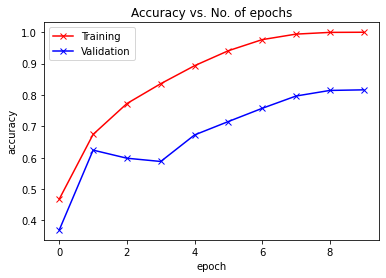

In [13]:
plot_accuracies(train_acclist, valid_acclist)

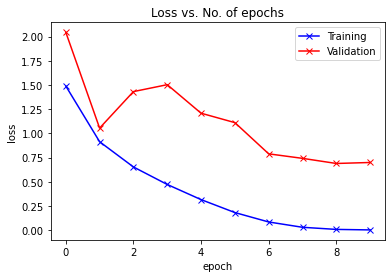

In [14]:
plot_losses(train_losslist, valid_losslist)

# Densely Connected Networks (DenseNet)

- ResNet significantly changed the view of how to parametrize the functions in deep networks. DenseNet (dense convolutional network) is to some extent the logical extension of this.


- Recall the Taylor expansion for functions. For the point $\mathbf{x}$ it can be written as:

$$
f(x)=f(0)+f^{\prime}(0) x+\frac{f^{\prime \prime}(0)}{2 !} x^{2}+\frac{f^{\prime \prime \prime}(0)}{3 !} x^{3}+\ldots
$$

- The key point is that it decomposes a function into increasingly higher order terms. In a similar vein, ResNet decomposes functions into:

$$
f(\mathbf{x})=\mathbf{x}+g(\mathbf{x})
$$


- That is, ResNet decomposes $f$ into a simple linear term and a more complex nonlinear one. What if we want to capture (not necessarily add) information beyond two terms? One solution was DenseNet:

![densenet-block.svg](./images/8/densenet-block.svg)


- As shown in the figure above, the key difference between ResNet and DenseNet is that in the latter case outputs are concatenated (denoted by $[,]$) rather than added. As a result, we perform a mapping from $\mathbf{x}$ to its values after applying an increasingly complex sequence of functions:

$$
\mathbf{x} \rightarrow\left[\mathbf{x}, f_{1}(\mathbf{x}), f_{2}\left(\left[\mathbf{x}, f_{1}(\mathbf{x})\right]\right), f_{3}\left(\left[\mathbf{x}, f_{1}(\mathbf{x}), f_{2}\left(\left[\mathbf{x}, f_{1}(\mathbf{x})\right]\right)\right]\right), \ldots\right]
$$


- The main components that compose a DenseNet are dense blocks and transition layers. The former define how the inputs and outputs are concatenated, while the latter control the number of channels so that it is not too large.

![densenet.svg](./images/8/densenet.svg)


In [15]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [16]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In [17]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
print(Y.shape)

torch.Size([4, 23, 8, 8])


In [18]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [19]:
blk = transition_block(23, 10)
print(blk(Y).shape)

torch.Size([4, 10, 4, 4])


In [20]:
def dense_net():
    b1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    # `num_channels`: the current number of channels
    num_channels, growth_rate = 64, 32
    num_convs_in_dense_blocks = [4, 4, 4, 4]
    blks = []
    for i, num_convs in enumerate(num_convs_in_dense_blocks):
        blks.append(DenseBlock(num_convs, num_channels, growth_rate))
        # This is the number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added between
        # the dense blocks
        if i != len(num_convs_in_dense_blocks) - 1:
            blks.append(transition_block(num_channels, num_channels // 2))
            num_channels = num_channels // 2
    return nn.Sequential(
        b1, *blks,
        nn.BatchNorm2d(num_channels), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(num_channels, 10))

In [21]:
densenet = dense_net()
X = torch.rand(size=(128, 3, 224, 224))
for layer in densenet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([128, 64, 56, 56])
DenseBlock output shape:	 torch.Size([128, 192, 56, 56])
Sequential output shape:	 torch.Size([128, 96, 28, 28])
DenseBlock output shape:	 torch.Size([128, 224, 28, 28])
Sequential output shape:	 torch.Size([128, 112, 14, 14])
DenseBlock output shape:	 torch.Size([128, 240, 14, 14])
Sequential output shape:	 torch.Size([128, 120, 7, 7])
DenseBlock output shape:	 torch.Size([128, 248, 7, 7])
BatchNorm2d output shape:	 torch.Size([128, 248, 7, 7])
ReLU output shape:	 torch.Size([128, 248, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([128, 248, 1, 1])
Flatten output shape:	 torch.Size([128, 248])
Linear output shape:	 torch.Size([128, 10])


In [22]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.model = dense_net()
    def forward(self, x):
        x = self.model(x)
        return x

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)
train_acclist, valid_acclist, train_losslist, valid_losslist = train_model(DenseNet(), "resnet", 10, device, learning_rate=0.1)

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86'] cuda
Use CUDA for training.
Epoch -> 1 	 train_loss -> 1.5628943147659302 			 train_acc -> 0.4287 
==========	 valid_loss -> 1.6010589416503906 			 valid_acc -> 0.432
Epoch -> 2 	 train_loss -> 1.1762095529937744 			 train_acc -> 0.5758800000190735 
==========	 valid_loss -> 1.253422795677185 			 valid_acc -> 0.5531
Epoch -> 3 	 train_loss -> 0.9664424502182006 			 train_acc -> 0.655159999961853 
==========	 valid_loss -> 1.1367299320220947 			 valid_acc -> 0.5736
Epoch -> 4 	 train_loss -> 0.822004592704773 			 train_acc -> 0.7062799999809265 
==========	 valid_loss -> 1.022229107761383 			 valid_acc -> 0.6517
Epoch -> 5 	 train_loss -> 0.7068197478103637 			 train_acc -> 0.752839999961853 
==========	 valid_loss -> 1.0086643013954162 			 valid_acc -> 0.6447
Epoch -> 6 	 train_loss -> 0.6153233733177185 			 train_acc -> 0.785539999961853 
==========	 valid_loss -> 1.1399584129333495 			 valid_acc -> 0.6278
Epoch -> 7 	 tr

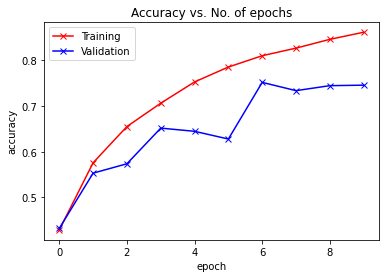

In [24]:
plot_accuracies(train_acclist, valid_acclist)

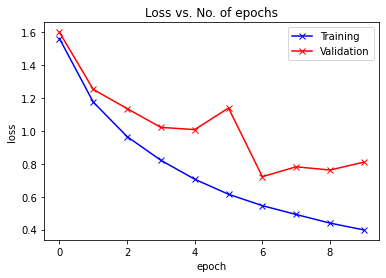

In [25]:
plot_losses(train_losslist, valid_losslist)

# How to rent a remote server?

![Navion-4U-GPU-Server-4124GS-TNR.jpg](./images/8/Navion-4U-GPU-Server-4124GS-TNR.jpg)
